# Decoding Tool

This script was used to develop the conditional word probability dataframe using Grapheme‑Phoneme Complexity data found in Berndt et al. (1987)

The script does the following

1. Calculate the difficulty of individual words based on spellings. So, (tap, /_taep_/) would be need to match t with /_t_/, a with /_ae_/ and p with /_p_/. Select the conditional probablity for the phoneme by the grapheme and divide it. Sum by grapheme for this division.

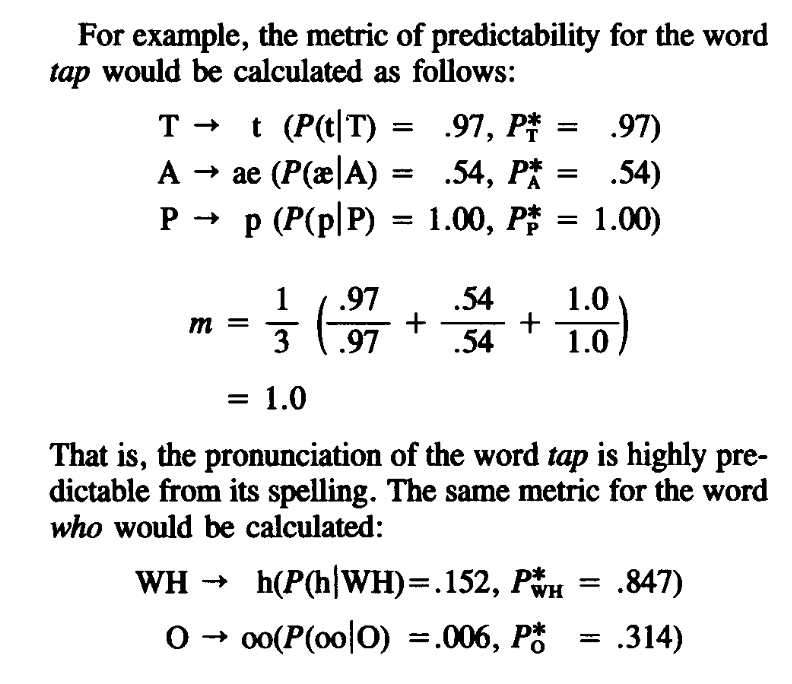
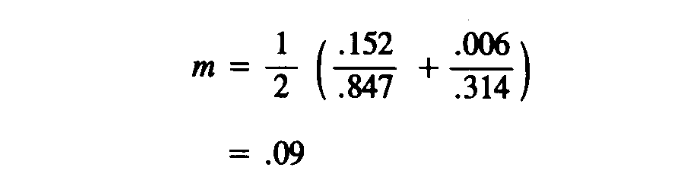

We use the CMU dictionary mixed with the Berndt et al. data to accomplish this.


## Setup

### Imports and utility functions

In [1]:
from collections import defaultdict
import re
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import spacy
from spacy.tokens import DocBin


def dict_print(target_dict, n=3):
    for key, value in list(target_dict.items())[:n]:
        print(f"{key=}: {value=}")

#### CMU dictionary setup

In [2]:
# Load CMU pronounciation dictionary from file
with open("pronounce_dic_tran.pkl", "rb") as f:
    pronounce_dic_tran = pickle.load(f)

# Create full cmu dictionary with the stresses removed to map to Berndt et al. (1987)
cmu_full = pronounce_dic_tran
cmu_full_nos = dict()
nums = [str(w) for w in range(10)]
for k, val in cmu_full.items():
    new_v = []
    for v in val:
        if v[-1] in nums:
            new_v.append(v[:-1])
        else:
            new_v.append(v)
    cmu_full_nos[k] = new_v
    
# Print out what the dictionary looks like
print("This is with stress")
dict_print(pronounce_dic_tran)

# Print out what the cmu dictionary looks like with no stress
print("This is without stress")
dict_print(cmu_full_nos)

This is with stress
key='A': value=['AH0']
key='AS': value=['EY1', 'Z']
key='A42128': value=['EY1', 'F', 'AO1', 'R', 'T', 'UW1', 'W', 'AH1', 'N', 'T', 'UW1', 'EY1', 'T']
This is without stress
key='A': value=['AH']
key='AS': value=['EY', 'Z']
key='A42128': value=['EY', 'F', 'AO', 'R', 'T', 'UW', 'W', 'AH', 'N', 'T', 'UW', 'EY', 'T']


#### Berndt dictionary setup

In [3]:
# Load csv with berndt consonants and vowels data merged into one
bdcp = pd.read_csv("berndt_data_with_cmu_phones_rerevised.csv", encoding='utf-8')
# Fill in grapheme column's empty (NaN) rows using forward fill
bdcp['Grapheme'] = bdcp['Grapheme'].ffill()

In [4]:
bdcp.head(7)

,Grapheme,Prior_prob,Phoneme,CMU_Phoneme,second CMU,Cond_prob,Example,Notes
0,A,0.0712,ae,AE1,NaN,0.542,cab,NaN
1,A,NaN,uh-,AH0,NaN,0.186,canal,NaN
2,A,NaN,ay,EY1,NaN,0.129,angel,NaN
3,A,NaN,ah,AA1,NaN,0.077,wad,NaN
4,A,NaN,aw,AO1,NaN,0.021,also,NaN
5,A,NaN,er,ER0,NaN,0.021,coward,NaN
6,A,NaN,eh,EH1,NaN,0.020,many,NaN


In [5]:
# Create dictionary of phonemes and their conditional probability using Berndt's dictionary
phoneme_dict = defaultdict(dict)

for phoneme, grapheme, prob in zip(bdcp['CMU_Phoneme'], bdcp['Grapheme'], bdcp['Cond_prob']):
    # Remove last character if it is a digit (remove stress)
    if phoneme and phoneme[-1].isdigit():
        phoneme = phoneme[:-1]
    phoneme_dict[phoneme.upper()][grapheme.upper()] = prob

# create a copy of the phoneme dictionary for later use
phoneme_dict_copied = phoneme_dict.copy()

# Print what the dictionary looks like
dict_print(phoneme_dict, n=1)

key='AE': value={'A': 0.542, 'A-E': 0.121, 'AH': 1.0, 'AI': 0.003, 'AU': 0.025, 'EA-E': 0.029, 'Y': 0.002}


In [6]:
# -----------------
# Revise Berndt's dictionary by adding phoneme-grapheme pairs

def merge_nested_dicts(dict1, dict2):
    result = dict1.copy()
    for key, value in dict2.items():
        if key in result and isinstance(result[key], dict) and isinstance(value, dict):
            result[key] = merge_nested_dicts(result[key], value)
        else:
            result[key] = value
    return result

# Dictionary created to be added to the Berndt dictionary
# np.nan will not affect mean conditional probability 
# and it will help the alogirthm skip unprocessable (but legitimate) phoneme-grapheme pairs

# {Phoneme: {Grapheme: None}} # Example word
revdict = {'Y': {"J":np.nan}, # JANSKY
           'AW': {"AU":np.nan}, # AUGSBURGER
           'AA': {"AA":np.nan}, # AABERG
           'IY': {"Y":np.nan}, # ANYTHING
           'ER': {"ER":np.nan, "EAR":np.nan}, # AFTER, EARTH 
           'EH': {"UE":np.nan}, # GUESS
           'Z': {"X":np.nan}, # XANAX
           'ZH': {"X":np.nan, "J":np.nan}, # XIAO, JACQUES
          }

# Revised full phoneme dictionary with no stress
phoneme_dict = merge_nested_dicts(phoneme_dict, revdict)

#### Spacy setup

In [ ]:
spacy_dict_path = Path("spacy_dict.spacy")

if not spacy_dict_path.exists():
    nlp = spacy.load("en_core_web_sm")
    doc_bin = DocBin(store_user_data=True)
    
    keys = list(cmu_full_nos.keys())
    for key, doc in tqdm(zip(keys, nlp.pipe(keys)), total=len(keys)):
        doc_bin.add(doc)
    
    # Save DocBin
    doc_bin.to_disk(spacy_dict_path)
    
    # Reconstruct dictionary from the DocBin
    spacy_dict = dict(zip(keys, doc_bin.get_docs(nlp.vocab)))
else:
    nlp = spacy.load("en_core_web_sm")
    doc_bin = DocBin().from_disk(spacy_dict_path)
    
    # Reconstruct keys from the docs themselves
    docs = list(doc_bin.get_docs(nlp.vocab))
    keys = [doc.text for doc in docs]
    
    # Reconstruct dictionary
    spacy_dict = dict(zip(keys, docs))

dict_print(spacy_dict)

key='A': value=A
key='AS': value=AS
key='A42128': value=A42128


#### Split CMU dictionary into root words v. others to process root words first

In [8]:
cmu_full_nos_roots = dict()
cmu_full_nos_remn = dict()

for k, v in cmu_full_nos.items():
    try:
        # Check if the word exists in spacy_dict and is its own lemma
        # This requires spacy_dict
        if k in spacy_dict and spacy_dict[k][0].lemma_ == spacy_dict[k][0].text.lower():
            cmu_full_nos_roots[k] = v
        else:
            cmu_full_nos_remn[k] = v
    except (KeyError, IndexError, AttributeError) as e:
        print(f"Error processing word '{k}': {e}")
        cmu_full_nos_remn[k] = v

Error processing word '': [E040] Attempt to access token at 0, max length 0.


### Match grapheme with lemma

In [9]:
# Set this to true for verbose results
SET_LOG = False

# Printing for debugging using icecream library
def log_ic(val):
    if SET_LOG:
        print(val)

# Main function
# Takes in word, phoneme, and whether the algorithm is going from front to back or from back to front
def phoneme_grapheme_match_lemma(word, phonemes, lemma_dict, front=True, second=True, uselemma=False):
    # Initialize variables to store results
    max_cond_probs = []
    min_word_remns = ""
    min_phonemes = []
    checkpoints = []
    prev_checkpoints = None
    consecutive_no_changes = 0
    original_word = word
    addon = []
    
    # Handle silent H at start of word
    if word[0] == "H" and phonemes[0] != "HH":
        original_word = word[1:]
    
    # Lemma-related features
    # This seems to hurt performance. Might need to revisit later. Turned off by default.
    # Switch uselemma=True in the argument to turn on
    if uselemma:
        # Check if the the current word contains a lemma that has already been processed
        try:
            word_lemma = spacy_dict[word][0].lemma_.upper()
        except:
            word_lemma = "NOT_FOUND"

        # If it does, use the existing processed information
        if word_lemma in lemma_dict:
            if lemma_dict[word_lemma][1] == phonemes[:len(lemma_dict[word_lemma][1])] and word_lemma == word[:len(word_lemma)]:
                original_word = word[len(word_lemma):]
                phonemes = phonemes[len(lemma_dict[word_lemma]):]
                addons = lemma_dict[word_lemma][0]

    # Loop while any grapheme is left unprocessed
    while word:
        
        # Reset grapheme list at the start of each loop
        word = original_word
        
        # List of conditional probabilities for current loop
        cond_probs = []
        
        # Checkpoints for current loop
        path = []
        
        # Iterate over phonemes
        for tier1_checkpoint, phoneme in enumerate(phonemes):
            # Hit will be set to True if a grapheme-phoneme pair is matched in a loop
            hit = False
            
            # Get all possible matching graphemes for the current phoneme
            targetdict = phoneme_dict[phoneme]
            
            # Start with longest grapheme
            targetdict_sorted = dict(sorted(targetdict.items(), key=lambda item: len(item[0]), reverse=True))
            
            for tier2_checkpoint, (grapheme_candidate, cond_prob) in enumerate(targetdict_sorted.items()):
                # use regex if necessary
                # for instances like "E-(1 or more consonants)-E" in "Edge"
                if "-" in grapheme_candidate:
                    # Only use this when processing from front to back
                    if front:
                        first, second = grapheme_candidate.split("-")
                        pattern = "^" + first + r"([^AEIOU]{1,2})" + second
                        fm = re.search(pattern, word)
                        if fm:
                            path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                            if path in checkpoints:
                                continue
                            # re-append the consonant part (e.g., 'dg' in 'Edge' after removing 'e-e')
                            word = fm.group(1) + word[len(fm[0]):]
                            # update conditional probability array for current main loop
                            cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                            if len(cond_probs) > len(max_cond_probs):
                                max_cond_probs = cond_probs.copy()
                                min_word_remns = word
                                min_phonemes = phonemes[tier1_checkpoint+1:]
                            hit = True
                            break
                    else:
                        pass
                # Check if there is a matching grapheme at the start of the word
                elif front and grapheme_candidate == word[:len(grapheme_candidate)]:
                    path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                    if path in checkpoints:
                        continue
                    word = word[len(grapheme_candidate):]
                    cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                    if len(cond_probs) > len(max_cond_probs):
                        max_cond_probs = cond_probs.copy()
                        min_word_remns = word
                        min_phonemes = phonemes[tier1_checkpoint+1:]
                    hit = True
                    break
                # Need different slicing when processing from back to front
                elif not front and grapheme_candidate == word[-len(grapheme_candidate):]:
                    path.append(f"{tier1_checkpoint}-{tier2_checkpoint}")
                    if path in checkpoints:
                        continue
                    word = word[:-len(grapheme_candidate)]
                    cond_probs.append([phoneme, grapheme_candidate, cond_prob])
                    if len(cond_probs) > len(max_cond_probs):
                        max_cond_probs = cond_probs.copy()
                        min_word_remns = word
                    hit = True
                    break
            # Keep track of bad paths so they're not visited again
            if not hit:
                if path != [] and path not in checkpoints:
                    checkpoints.append(path)
                break
        # Check if the current path has been explored
        if checkpoints != prev_checkpoints:
            prev_checkpoints = checkpoints.copy()  # Update the previous state
            consecutive_no_changes = 0  # Reset the counter
        # If current path has been explored previously, increment counter
        else:
            consecutive_no_changes += 1  # Increment the counter
        # If the list hasn't changed for two consecutive loops, break the loop
        if consecutive_no_changes == 2:
            if path[:-1] not in checkpoints:
                checkpoints.append(path[:-1])
        elif consecutive_no_changes >3:
            break
            
    # Re-run this function after from back to front with remaining phonemes if there are unprocessed graphemes
    if word and second and word != original_word and len(min_phonemes) != 0:
        mcp2, min_word_remns, lemma_dict = phoneme_grapheme_match_lemma(min_word_remns, min_phonemes, lemma_dict, front=False, second=False)
        max_cond_probs += mcp2
    
    # Clean-up and update lemma dictionary if all words have been processed, 
    if not word:
        min_word_remns = ""
        if uselemma and front and word_lemma == original_word:
            lemma_dict[original_word] = [max_cond_probs, phonemes]
    
    max_cond_probs += addon
    
    return max_cond_probs, min_word_remns, lemma_dict

# function that does both front-back and back-front approach and returns the best result
def front_back_lemma(word, phonemes, lemma_dict):
    condprobs, word_remns, lemma_dict = phoneme_grapheme_match_lemma(word, phonemes, lemma_dict, front=True)
    if word_remns != []:
        back_condprobs, back_word_remns, lemma_dict = phoneme_grapheme_match_lemma(word, phonemes[::-1], lemma_dict, front=False)
        condprobs = max(condprobs, back_condprobs, key=len)
        word_remns = min(word_remns, back_word_remns)
    return condprobs, word_remns, lemma_dict

In [10]:
# Run the above for the full CMU items
# Initialize arrays for DF
wds = []
phnms = []
cond_probs_master = []
word_remns = []
proc_pers = []
cps = []
lemma_dict = dict()
SET_LOG = False

# Start with words where lemma=word
for word, phonemes in tqdm(cmu_full_nos_roots.items()):
    if word and phonemes:
        max_cond_probs, min_word_remns, lemma_dict = front_back_lemma(word, phonemes, lemma_dict)
        wds.append(word)
        phnms.append(phonemes)
        cond_probs_master.append(max_cond_probs)
        word_remns.append(len(phonemes)-len(max_cond_probs))
        proc_pers.append(len(max_cond_probs)/len(phonemes))
        if not max_cond_probs:
            cps.append(0)
        else:
            cps.append(np.mean([w[2] for w in max_cond_probs if not np.isnan(w[2])]))

# Do the rest
for word, phonemes in tqdm(cmu_full_nos_remn.items()):
    if word and phonemes:
        max_cond_probs, min_word_remns, lemma_dict = front_back_lemma(word, phonemes, lemma_dict)
        wds.append(word)
        phnms.append(phonemes)
        cond_probs_master.append(max_cond_probs)
        word_remns.append(len(phonemes)-len(max_cond_probs))
        proc_pers.append(len(max_cond_probs)/len(phonemes))
        if not max_cond_probs:
            cps.append(0)
        else:
            cps.append(np.mean([w[2] for w in max_cond_probs if not np.isnan(w[2])]))

  3%|▎         | 844/26790 [00:00<00:06, 4218.75it/s]/Users/crossls/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/crossls/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 94963/94963 [00:19<00:00, 4828.10it/s]


In [11]:
# Create dataframe
processed = pd.DataFrame({"Word":wds, 
             "Phonemes":phnms, 
             "Conditional Probablility":cond_probs_master,
             "Unprocessed phonemes":word_remns,
             "Processed percentage": proc_pers,
             "Conditional Probability Average": cps})

In [12]:
# Descriptive stats
processed.describe()

,Unprocessed phonemes,Processed percentage,Conditional Probability Average
count,121752.000000,121752.000000,121742.000000
mean,0.437348,0.937616,0.675740
std,1.173152,0.156018,0.142198
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.588105
50%,0.000000,1.000000,0.683000
75%,0.000000,1.000000,0.769833
max,19.000000,1.000000,1.000000


In [13]:
# First 50 rows
processed.head(50)

,Word,Phonemes,Conditional Probablility,Unprocessed phonemes,Processed percentage,Conditional Probability Average
0,A,[AH],"[[AH, A, 0.0005]]",0,1.000000,0.000500
1,AS,"[EY, Z]","[[EY, A, 0.129], [Z, S, 0.12]]",0,1.000000,0.124500
2,AABERG,"[AA, B, ER, G]","[[AA, AA, nan], [B, B, 1.0], [ER, ER, nan], [G...",0,1.000000,0.820000
3,AAMODT,"[AA, M, AH, T]","[[AA, AA, nan], [M, M, 0.971], [AH, O, 0.002]]",1,0.750000,0.486500
4,AARONSON,"[EH, R, AH, N, S, AH, N]","[[N, N, 0.967], [AH, O, 0.002], [S, S, 0.868],...",0,1.000000,0.546571
5,AARONSONS,"[EH, R, AH, N, S, AH, N, Z]","[[Z, S, 0.12], [N, N, 0.967], [AH, O, 0.002], ...",0,1.000000,0.493250
6,AASEN,"[AA, S, AH, N]","[[N, N, 0.967], [AH, E, 0.096], [S, S, 0.868],...",0,1.000000,0.643667
7,AB,"[AE, B]","[[AE, A, 0.542], [B, B, 1.0]]",0,1.000000,0.771000
8,ABACO,"[AE, B, AH, K, OW]","[[AE, A, 0.542], [B, B, 1.0], [AH, A, 0.0005],...",0,1.000000,0.522700
9,ABANTO,"[AH, B, AE, N, T, OW]","[[AH, A, 0.0005], [B, B, 1.0], [AE, A, 0.542],...",0,1.000000,0.632750


In [ ]:
# Simplest pandas export: one line
processed.to_csv("processed_condprobs_v4_final.csv", index=False)